In [1]:
'''
Adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/
'''

'\nAdapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/\n'

In [2]:
import requests
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(input_train, target_train), (input_test, target_test) = tf.keras.datasets.mnist.load_data("/Users/dominik.waibel/Desktop/VAE/mnist.npz")

In [4]:
print(np.shape(input_train))

(60000, 28, 28)


In [5]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 10
validation_split = 0.2
verbosity = 1
latent_dim = 4
num_channels = 1

In [6]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [7]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)

# Take away the flattening and mu, sigma layers from the VAE
#x       = Flatten()(cx)
#x       = Dense(latent_dim, activation='relu')(x)
#x       = BatchNormalization()(x)
#mu      = Dense(latent_dim, name='latent_mu')(x)
#sigma   = Dense(latent_dim, name='latent_sigma')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)
print(conv_shape[1:])

(7, 7, 16)


In [9]:
# Instantiate encoder
encoder = Model(i, cx, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
Total params: 1,344
Trainable params: 1,296
Non-trainable params: 48
_________________________________________________________________


In [21]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(conv_shape[1:]), name='decoder_input')

# Take away the flattening and mu, sigma layers from the VAE
#x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
#x     = BatchNormalization()(x)
#x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(d_i)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [22]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 7, 7, 16)]        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 8)         1160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         73        
Total params: 3,649
Trainable params: 3,601
Non-trainable params: 48
________________________________________________________

In [23]:

# Instantiate VAE
vae_outputs = decoder(encoder(i))
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 7, 7, 16)          1344      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         3649      
Total params: 4,993
Trainable params: 4,897
Non-trainable params: 96
_________________________________________________________________


In [24]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [25]:
# Compile VAE
vae.compile(optimizer='adam', loss="mse")

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 20s 414us/sample - loss: 0.0303 - val_loss: 0.0061
Epoch 2/10
48000/48000 [==============================] - 20s 421us/sample - loss: 0.0049 - val_loss: 0.0038
Epoch 3/10
48000/48000 [==============================] - 19s 395us/sample - loss: 0.0027 - val_loss: 0.0026
Epoch 4/10
48000/48000 [==============================] - 19s 400us/sample - loss: 0.0016 - val_loss: 0.0019
Epoch 5/10
48000/48000 [==============================] - 19s 397us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 6/10
48000/48000 [==============================] - 19s 399us/sample - loss: 9.1507e-04 - val_loss: 0.0011
Epoch 7/10
48000/48000 [==============================] - 19s 397us/sample - loss: 8.2101e-04 - val_loss: 0.0011
Epoch 8/10
48000/48000 [==============================] - 20s 411us/sample - loss: 7.2849e-04 - val_loss: 6.7377e-04
Epoch 9/10
48000/48000 [==============================] - 19s 

In [42]:
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu = encoder.predict(input_data)
    print(np.shape(mu))
    print(np.min(mu),np.max(mu))
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    mu1 = np.zeros((10000,784))
    mu1[:,0] = mu[:,0,0,0]
    mu1[0,:] = np.ravel(mu[0,:])
    pca_x = pca.fit_transform(mu1)
    plt.figure(figsize=(8, 10))
    plt.scatter(pca_x[:, 0], pca_x[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

(10000, 7, 7, 16)
-2.3837729 5.6294937


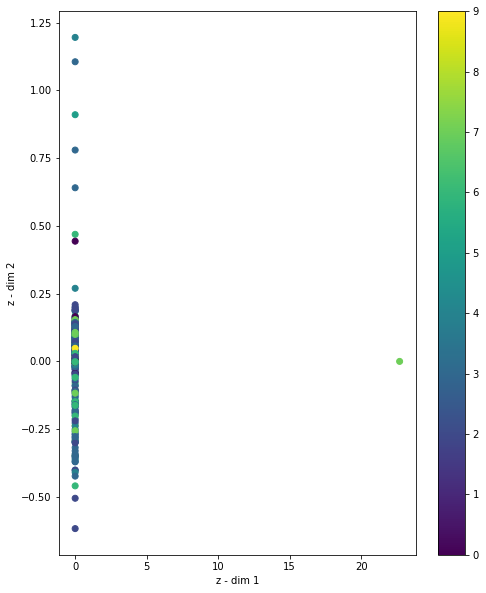

In [43]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

In [59]:
import random
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            #z_sample = np.array([[0,0,xi, yi]])
            z_sample = []
            z_sample1 = np.random.rand(10000, 7, 7, 16)
            z_sample2 = np.random.rand(10000, 7, 7, 16)
            z_sample = z_sample1-z_sample2
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
        # Show image
        plt.imshow(figure)
        plt.show()

(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7, 7, 16)
(10000, 7,

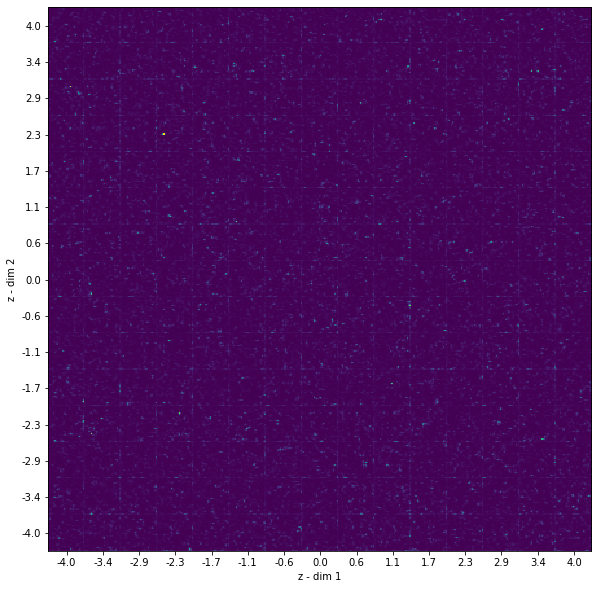

In [60]:
viz_decoded(encoder, decoder, data)